## **CS235 Project Part 1**


### Kelsey Musolf


#### SID: 862191249

*****************************************************
## **Part 1.1 Data cleaning & missing value prediction [50%]**

We are going to create different noisy versions of our dataset and then apply a number of
denoising functions and measure their effectiveness. The type of noise we will introduce is in the
form of missing values. In particular, we will make two variants of missing data noise:
- Single feature: For p% of all the data points, replace the value of the first feature
(‘radius’) with ‘nan’.
- Feature at random: For p% of all the data points, select a feature uniformly at random
and replace its value with ‘nan’
In order to restore the missing values, we are going to use the ‘impute’ function of Scikit-learn:
https://scikit-learn.org/1.5/modules/impute.html. More specifically, we are going to compare the
two different types of imputation (SimpleImputer vs. IterativeImputer). For the purposes of
reducing the amount of plots, please use the default options for both imputers, however, I would
highly encourage you to tweak the options and observe what is the effect. It is important to note
that imputation should be applied to the train and test sets independently, otherwise there will
be some leakage of information from train to test.
What to plot: For p = [20%, 40%], you should produce a figure for each value of p that compares
the performance of logistic regression on the two noisy variants of our dataset before and after
imputation, for both types of imputation (total of 6 performance values per figure).

***********************

## Process For Denoising

I copy the X data and replace 20% of the 'radius_mean' values with NAN.
This is saved 3 times to run tests on later:
1. one for Before Imputation
2. one for Single Imputation
3. one for Random Imputation

I repeat this again, this time with replacing 40% of the data in 'radius_mean'


All values are saved and plotted at the end

Libraries used for parts 1.1 and 1.2

In [1020]:
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



Getting the data, splitting into 20% and 40% missing data in 'radius_mean' column. 

I copy the data set X to change two times. One time randomly changing 20% of the 'radius_mean' feature to Nan (saved as X_20) and again but with 40% changed data to Nan (X_40).

In [1021]:

df = pd.read_csv('wdbc.data', header=None)


# separate the data (X) from the target 'diagnosis' (y)
# drop 'id' (unique, will mess up values) and 'diagnosis' (value we are trying to get) 
y = df.iloc[:, 1] 
X = df.drop(df.columns[[0, 1]], axis=1)


# copy X and replace 20% of radius with NAN
X_20 = X.copy()

# get 20% of column, randomly select indicies, replace these with Nan
replacement_20 = int(len(X) * 0.2)
np.random.seed(42) 
missing_indices_20 = np.random.choice(X.index, replacement_20, replace=False)
X_20.iloc[missing_indices_20, 0] = np.nan




#========REPEAT WITH 40==========

#copy X and replace 40% of radius with NAN
X_40 = X.copy()


#get 40% of column randomly and replace
replacement_40 = int(len(X) * 0.4)
np.random.seed(43) 
missing_indices_40 = np.random.choice(X.index, replacement_40, replace=False)
X_40.iloc[missing_indices_40, 0] = np.nan



#now have all data sets ready to work on!
#print(X_20)
#print(X_40)

# will store averages for plotting
results = []


To run each denoising method, I have created a function that will be called each time. It goes through the following steps to return the mean and standard deviation:

1. Take in parameters
    - data set X, target y, imputer type, the value to replace Nans, splits for k fold, and if Nans are dropped or not
2. Check for imputer type.
    - I am using this function for dropping Nans, Single Imputation, and Iterative Imputation
3. 

*******************************
#### Function
Stratified K Fold with Log Regression and Imputation 

In [1022]:

def strat_k_fold(X, y, imputer_type, impute_value = 0 , n_splits=5, dropna=False):

    # Convert target to binary
    y_binary = y.map({'M': 1, 'B': 0}) if y.dtype == object else y

    # Drop rows with NaN values (if requested)
    if dropna:
        X = X.dropna()
        # align y with X after dropping 
        y_binary = y_binary[X.index]  


    # Select the imputer from parameters:
    #Single Imputer is default if nothing is selected
    if imputer_type == 'iterative':
        imputer = IterativeImputer(random_state=42)
    elif imputer_type == 'constant':
        imputer = SimpleImputer(strategy='constant', fill_value=impute_value)
    else:  
        imputer = SimpleImputer(strategy=imputer_type)

    # pipeline for order of steps:
    pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000))
    ])

    # Stratified K Fold, n_splits is always 5 for these, store in f1_scores array
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []

    #with k fold, split into train and test, train_idx from strat k fold => 'skf'
    for train_idx, test_idx in skf.split(X, y_binary):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]

        #run the train on pipeline, apply to predict test, save to f1_scores
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))

    #return
    return f1_scores, np.mean(f1_scores), np.std(f1_scores)



Most of code is finished here. Function allows me to call each time with either X_20 data set where 20% of data is missing, or X_40 where 40% of data is missing.

Will run for both sets 3 times. One where I drop the Nan values, one with Single Imputation (fill the missing with mean) and one with Iterative Imputation (fill with values gotten from other attributes)


#### Calling the Function

1. Missing data dropped 20% and 40%
    - Printed below

In [1023]:
# 20% missing radius_mean, fill with 0s
scores_20, avg_20, std_20 = strat_k_fold(X_20, y, imputer_type='constant', impute_value=0, dropna=True)
print("Average F1 Score (20% missing, NaN dropped):", avg_20)

# 40% missing radius_mean, fill with 0s
scores_40, avg_40, std_40 = strat_k_fold(X_40, y, imputer_type='constant', impute_value=0, dropna=True)
print("Average F1 Score (40% missing, NaN dropped):", avg_40)

Average F1 Score (20% missing, NaN dropped): 0.9646077910841052
Average F1 Score (40% missing, NaN dropped): 0.9742710120068612


2. Single Imputation 20% and 40%:
    - Printed below

In [1024]:
scores_20_single, avg_20_single, std_20_single = strat_k_fold(X_20, y, imputer_type='mean')
print("Average F1 Score (20% missing, filled with mean):", avg_20_single)



scores_40_single, avg_40_single, std_40_single = strat_k_fold(X_40, y, imputer_type='mean')

print("Average F1 Score (40% missing, filled with mean):", avg_40_single)


Average F1 Score (20% missing, filled with mean): 0.9633408685451746
Average F1 Score (40% missing, filled with mean): 0.9659951895328289


3. Iterative Imputation 20% and 40%:
    - Printed below

In [1025]:
scores_20_itr, avg_20_itr, std_20_itr = strat_k_fold(X_20, y, imputer_type='iterative')
print("Average F1 Score (20% missing, filled with iterative method):", avg_20_itr)



scores_40_itr, avg_40_itr, std_40_itr = strat_k_fold(X_40, y, imputer_type='iterative')

print("Average F1 Score (40% missing, filled with iterative method):", avg_40_itr)

Average F1 Score (20% missing, filled with iterative method): 0.9633408685451746
Average F1 Score (40% missing, filled with iterative method): 0.9633408685451746


#### Graph results for radius_mean 

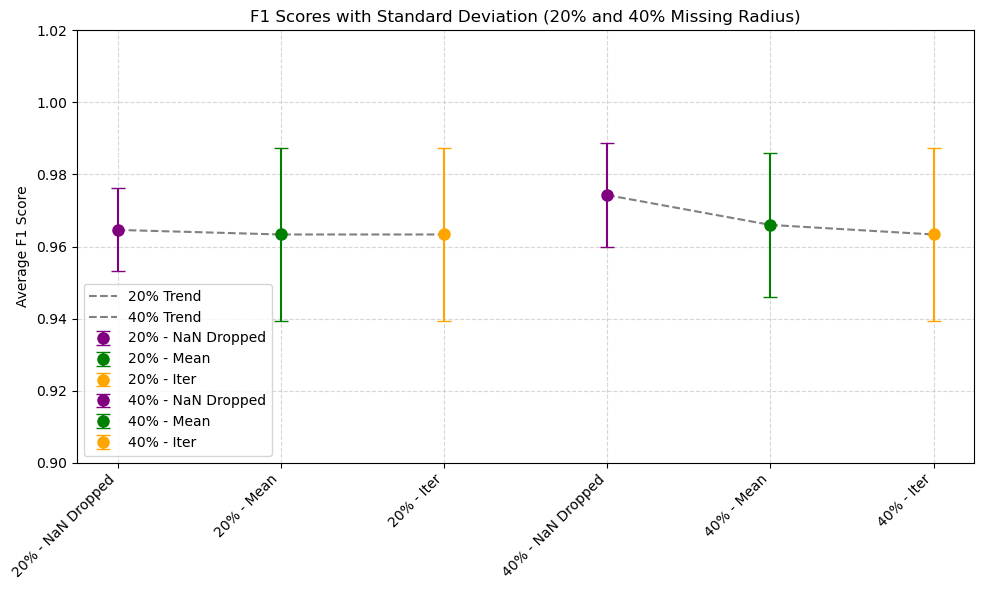

In [1026]:
# x-axis names:
labels = ['20% - NaN Dropped', '20% - Mean', '20% - Iter', 
          '40% - NaN Dropped', '40% - Mean', '40% - Iter']

# saved values from before
means = [avg_20, avg_20_single, avg_20_itr,
         avg_40, avg_40_single, avg_40_itr]

stds = [std_20, std_20_single, std_20_itr,
        std_40, std_40_single, std_40_itr]

# plot it
plt.figure(figsize=(10, 6))

colors = ['purple', 'green', 'orange', 'purple', 'green', 'orange']

# error bar
for i in range(len(labels)):
    plt.errorbar(i, means[i], yerr=stds[i], fmt='o', 
                 label=labels[i], color=colors[i], capsize=5, markersize=8)
    
# styling error bar
x_20 = [0, 1, 2]
y_20 = means[:3]
plt.plot(x_20, y_20, linestyle='--', color='gray', label='20% Trend')

x_40 = [3, 4, 5]
y_40 = means[3:]
plt.plot(x_40, y_40, linestyle='--', color='gray', label='40% Trend')

# Format graph points (adding title and y-axis label)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Average F1 Score')
plt.title('F1 Scores with Standard Deviation (20% and 40% Missing Radius)')
plt.ylim(0.90, 1.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### **Important!**
Looking at the graph, there is some surprising behavior. Logically, the dropping of missing values in the radius_mean column should have a worse prediction of the results. It is predicting with less information and does not have the full scope of radius_mean. This would also then, logically mean that filling the NaN values with the mean or using the iterative approach would be better. This unexpected behavior is most likely an error with my code. I have also tested filling NaN values with 0 instead of dropping them, this returns the same results as above. 

One explanation for better results with dropped NaN values is if the dropped values are outliers or dont accuratly reflect the data well. This means that by leaving them out, the predictions are better. It could also be explain if filling the NaN values with the mean overfits the data, resulting in specific predictions that dont generalize well. If the data was skewed, the mean would be worse at predicting htis than the dropped NaN values. While I do not beleive these cases to be true in this data set, they are possible explanations for a better dropped NaN prediction than using the mean or iterative approach.

I have talked with the professor about this matter, he has allowed me to continue on with no reduction as long as I explain why this behavior is unexpected and a possible reason for it. (Also discussed via email with TA Miguel)

***********************
####  ***Continue: Perform on a Random Attribute***

I now repeat all the steps from above with a random attribute instead of the radius_mean. 

1. 20% missing:
    - drop NaNs
    - Single Imputation
    - Iterative Imputation

2. 40% missing:
    - drop NaNs
    - Single Imputation
    - Iterative Imputation

I will still use the same function from radius_mean, passing in the new dataset with the random feature. 


Create data sets again, this time selecting a random feature / attribute to change and fill with Nan instead of 'radius_mean'. I must perform two times for 20% and 40%

In [1027]:
# X from second cell block, just from data set => wdbc.data
rand_X_20 = X.copy()

# randomly select one feature (column)
random_feature = np.random.choice(rand_X_20.columns)

# replace rows (20%)
n_rows = len(rand_X_20)
n_missing = int(0.2 * n_rows)

# random selection for indices
missing_indices = np.random.choice(rand_X_20.index, size=n_missing, replace=False)

#replace indicies above with nan
rand_X_20.loc[missing_indices, random_feature] = np.nan

Repeat again for 40% of data:

In [1028]:
# create new version with 40% of values in one random feature replaced by NaN
rand_X_40 = X.copy()

#selecting feature
random_feature = np.random.choice(rand_X_40.columns)

#getting size (40%)
n_rows = len(rand_X_40)
n_missing = int(0.4 * n_rows)

#indicies to replace
missing_indices = np.random.choice(rand_X_40.index, size=n_missing, replace=False)

#replace with NaN
rand_X_40.loc[missing_indices, random_feature] = np.nan

*****************
#### Functions:

Redid code for dropping, single imputation and iterative imputation. I wanted to try (yet another) method to find average and std. dev. scores for f1, this time hoping for a better trend. (spoiler: I still have the same problem).

**Drop NaN Values**

In [1029]:

def evaluate_dropped(X, y):

    #skf with 5 folds, save in f1_scores
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    #split into train and test data from skf
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # drop rows with NaNs
        train_mask = ~X_train.isna().any(axis=1)
        test_mask = ~X_test.isna().any(axis=1)

        X_train_clean = X_train[train_mask]
        y_train_clean = y_train[train_mask]
        X_test_clean = X_test[test_mask]
        y_test_clean = y_test[test_mask]

        # Scale after dropping NaNs
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_clean)

        # Train model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train_clean)
        preds = model.predict(X_test_scaled)

        # Compute F1 score
        f1_scores.append(f1_score(y_test_clean, preds, pos_label='M'))

    return np.mean(f1_scores), np.std(f1_scores)


**Single Imputation**

In [1030]:
def evaluate_simple_impute(X, y):

    #skf, 5 folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    #order to compute
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    #split into train and test data from skf
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        #run through pipeline, replacing NaN with mean value, predicting and adding to f1_scores
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        f1_scores.append(f1_score(y_test, preds, pos_label='M'))

    #return
    return np.mean(f1_scores), np.std(f1_scores)


**Iterative Imputation**

In [1031]:
def evaluate_iterative_impute(X, y):

    #skf, folds = 5, store in f1_scores
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    #order to compute
    pipe = Pipeline([
        ('imputer', IterativeImputer(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    #split into train and test data
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        #run through pipeline, replacing NaN with mean value, predicting and adding to f1_scores
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        f1_scores.append(f1_score(y_test, preds, pos_label='M'))

    #return
    return np.mean(f1_scores), np.std(f1_scores)


*****************
Running all functions for 20%
 - Printing out F1 mean and std. dev.

In [1032]:
drop_mean_20, drop_std_20 = evaluate_dropped(rand_X_20, y)
simple_mean_20, simple_std_20 = evaluate_simple_impute(rand_X_20, y)
iterative_mean_20, iterative_std_20 = evaluate_iterative_impute(rand_X_20, y)

print(f"Drop NaNs      - F1: {drop_mean_20:.4f} ± {drop_std_20:.4f}")
print(f"Simple Impute  - F1: {simple_mean_20:.4f} ± {simple_std_20:.4f}")
print(f"Iterative Impute - F1: {iterative_mean_20:.4f} ± {iterative_std_20:.4f}")


Drop NaNs      - F1: 0.9593 ± 0.0259
Simple Impute  - F1: 0.9638 ± 0.0205
Iterative Impute - F1: 0.9633 ± 0.0240


Running all functions for 40%
 - Printing out F1 mean and std. dev.

In [1033]:
drop_mean_40, drop_std_40 = evaluate_dropped(rand_X_40, y)
simple_mean_40, simple_std_40 = evaluate_simple_impute(rand_X_40, y)
iterative_mean_40, iterative_std_40 = evaluate_iterative_impute(rand_X_40, y)

print(f"Drop NaNs      - F1: {drop_mean_40:.4f} ± {drop_std_40:.4f}")
print(f"Simple Impute  - F1: {simple_mean_40:.4f} ± {simple_std_40:.4f}")
print(f"Iterative Impute - F1: {iterative_mean_40:.4f} ± {iterative_std_40:.4f}")


Drop NaNs      - F1: 0.9802 ± 0.0266
Simple Impute  - F1: 0.9633 ± 0.0240
Iterative Impute - F1: 0.9633 ± 0.0240


#### Graph Results for Random Attribute

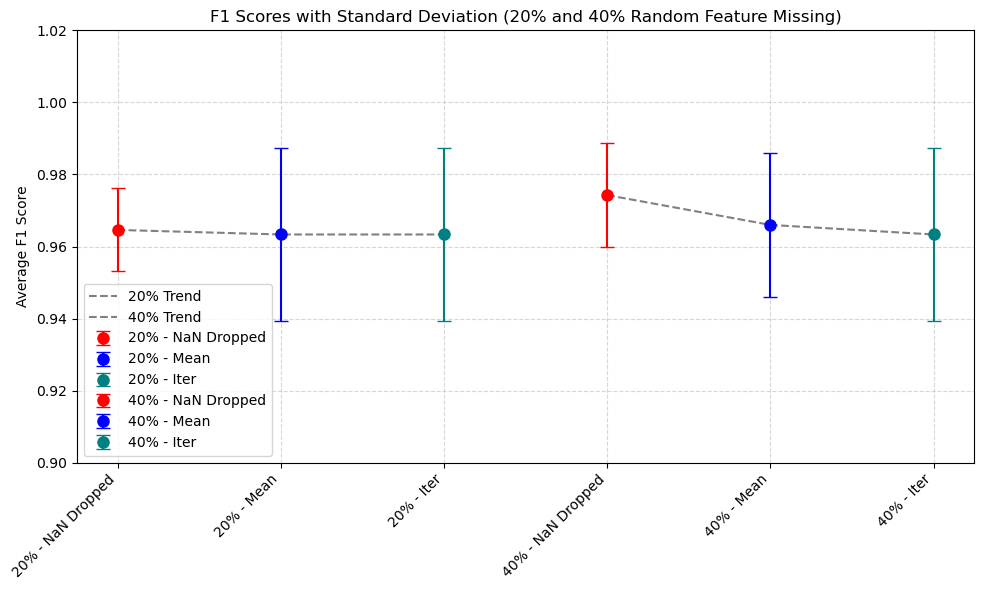

In [1034]:
# x-axis names:
labels = ['20% - NaN Dropped', '20% - Mean', '20% - Iter', 
          '40% - NaN Dropped', '40% - Mean', '40% - Iter']

# saved values from before
means = [avg_20, avg_20_single, avg_20_itr,
         avg_40, avg_40_single, avg_40_itr]

stds = [std_20, std_20_single, std_20_itr,
        std_40, std_40_single, std_40_itr]

# plot it
plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'teal', 'red', 'blue', 'teal']

# error bar
for i in range(len(labels)):
    plt.errorbar(i, means[i], yerr=stds[i], fmt='o', 
                 label=labels[i], color=colors[i], capsize=5, markersize=8)
    
# styling error bar
x_20 = [0, 1, 2]
y_20 = means[:3]
plt.plot(x_20, y_20, linestyle='--', color='gray', label='20% Trend')

x_40 = [3, 4, 5]
y_40 = means[3:]
plt.plot(x_40, y_40, linestyle='--', color='gray', label='40% Trend')

# Format graph points (adding title and y-axis label)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Average F1 Score')
plt.title('F1 Scores with Standard Deviation (20% and 40% Random Feature Missing)')
plt.ylim(0.90, 1.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### **Important!**

Repeated strange behavior. Once again my code shows the dropped NaN values to be better than the two imputation methods. Refer back to first chart to see my explanation. 


### What I Expected:

With the three different methods, I expected Iterative imputation to have the best predictions. It is based on all the ther features of the train data and this means it has more dimensions to base the predictions on. 
Single Imputation is based solely on the one column's mean, so it should be a better method than dropping NaNs, but worse than iterative imputation. 

### Comparing the Two Graphs:

Looking at both graps, they are showing similar results. The column predictions are not affected much, but it is the imputation method that does affect the accuracy. 

******************
******************

## **Part 1.2 Dimensionality reduction [50%]**

We are going to compare how two different dimensionality reduction techniques affect the
performance. More specifically, we are going to use:
- Singular Value Decomposition: The Singular Value Decomposition (SVD) is an
extremely useful tool from linear algebra that can help us approximate a data matrix
(such as the instance-by-feature matrix that represents our data) into a smaller
dimension, hence reduce the dimensionality of the data. In this question you should use
the SVD (you may use the existing NumPy library) to approximate the data in different
ranks. Because we are dealing with supervised learning, given a train/test split, in order
to avoid data leakage you should always make sure that you only compute the SVD on
the train split and project the test instances to that space, in the same way that the
Latent Semantic Analysis paper does.
- Autoencoder: In certain ways, the autoencoder is the neural network alternative to the
SVD, where an encoder network produces an intermediate (latent) representation of that
data, and a decoder network transforms the data back to the original space, while
ensuring during training that the decoded output is as close to the input as possible. For 
the purposes of this exercise, your autoencoder should have two hidden layers, with
widths equal to (a) min(d,2*k) (where d is the original dimensionality of your data) and
(b) k respectively (and accordingly for the decoder), and with ReLU activation functions.
You may use Scikit-learn functionality to train your autoencoder. Similar to the SVD, the
autoencoder should only be trained on the train set and only applied to the test set. The
output of the encoder will be the new latent representation of the data.



************************

## Process and Code for SVD

Starting with Singular Value Decomposition. This is taking our data and splitting it into 3 matricies. These matricies are used to determine the important features and scale them down to a smaller umber that can still accurately predict the data / train the data to get the target value. 

My task is to run SVD with different k values, to change the number of attributes used to predict the data. This comes from the middle matrix, which is diagonal and sorted hierarchically on importance for predicting the data in decreasing order. 

*************************

Stepping through my code, I use Stratified K Fold to split my data into training and testing groups. I scale the data to avoid data leakage (test and train data being in both groups) and then run SVD on the training data (getting the important attributes, dropping insignificant values, preparing for prediction). To finish, and I use logarithmic regression on the training data and call .predict() to get my F1 scores. 

In [1035]:
#function for SVD, X is data set, y is target, n_components is number of attributes used (k)
def evaluate_svd(X, y, n_components):

    #get 5 folds for train and test - stratified K fold - skf
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # save f1_scores
    f1_scores = []


    #splitting the data into the folds
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # scale before SVD, before because leakage!!!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # use SVD on training data
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_train_reduced = svd.fit_transform(X_train_scaled)
        X_test_reduced = svd.transform(X_test_scaled)

        # on the train data, use log regression:
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_reduced, y_train)

        # predict (preds) with the M from target data y, add to f1
        preds = clf.predict(X_test_reduced)
        f1 = f1_score(y_test, preds, pos_label='M')
        f1_scores.append(f1)

    #return mean and std
    return np.mean(f1_scores), np.std(f1_scores)


I now call the function 3 times, changing the k value each time to run with a different number of dimensions 2, 5, and 10. I save the mean and standard deviation. 

In [1036]:

#save all results to be plotted
SVD_f1_scores = []

#run with different k values to test different attributes included
for k in [2, 5, 10]:
    mean_f1, std_f1 = evaluate_svd(X, y, n_components=k)
    SVD_f1_scores.append((k, mean_f1, std_f1))
    print(f"SVD {k} features: F1 = {mean_f1:.4f} ± {std_f1:.4f}")


SVD 2 features: F1 = 0.9284 ± 0.0329
SVD 5 features: F1 = 0.9501 ± 0.0207
SVD 10 features: F1 = 0.9692 ± 0.0094


************************

## Process and Code for AutoEncoder

Added libraries for AutoEncoder function:

In [1037]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

In the code below, auto encoder takes the data in X, encodes it with hidden layers, and then when X is needed to be retreived, it can be decoded with more hidden layers. 

Hidden layers, what are they? These laers are given in the method project descripton, but what they are doing is taking the data set X and reducing the dimensions. I can see the data represented with fewer dimensions in space and is done so by training and testing the data to see how well the low dimensionality can represent the original data set. 

Autoencoder is a different method for testing low dimensionality on my data set! I will graph it and compare it to SVD method below.

In [1038]:

def evaluate_autoencoder(X, y, k):

    #take our input and label d
    d = X.shape[1]
    #first hidden layer
    hidden1 = min(d, 2 * k)

    #use skf to train and test data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    #splitting into train and test
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # train autoencoder - input, to hidden layer 1, to k. this can go back to hidden layer 1
        autoencoder = MLPRegressor(hidden_layer_sizes=(hidden1, k, hidden1),
                                   activation='relu', max_iter=2000, random_state=42)
        autoencoder.fit(X_train_scaled, X_train_scaled)

        # encoder here... 
        encoder = MLPRegressor(hidden_layer_sizes=(hidden1, k),
                               activation='relu', max_iter=1)  
        encoder.coefs_ = autoencoder.coefs_[:2]
        encoder.intercepts_ = autoencoder.intercepts_[:2]

        # train and test with encode:
        def relu(x): return np.maximum(0, x)
        h1_train = relu(np.dot(X_train_scaled, encoder.coefs_[0]) + encoder.intercepts_[0])
        X_train_encoded = relu(np.dot(h1_train, encoder.coefs_[1]) + encoder.intercepts_[1])

        h1_test = relu(np.dot(X_test_scaled, encoder.coefs_[0]) + encoder.intercepts_[0])
        X_test_encoded = relu(np.dot(h1_test, encoder.coefs_[1]) + encoder.intercepts_[1])

        # classify on encoded data
        #using log regression again, predicting values (when encoded) and saving mean and std. dev.
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_encoded, y_train)
        preds = clf.predict(X_test_encoded)
        f1 = f1_score(y_test, preds, pos_label='M')
        f1_scores.append(f1)

    return np.mean(f1_scores), np.std(f1_scores)


I now call the function 3 times, changing the k value each time to run with a different number of dimensions 2, 5, and 10. I save the mean and standard deviation. 

In [1039]:
#store in new array AutoEncoder for plotting on graph
AE_f1_scores = []

for k in [2, 5, 10]:
    mean_f1, std_f1 = evaluate_autoencoder(X, y, k)
    AE_f1_scores.append((k, mean_f1, std_f1))
    print(f"Autoencoder {k} features: F1 = {mean_f1:.4f} ± {std_f1:.4f}")


Autoencoder 2 features: F1 = 0.9129 ± 0.0284
Autoencoder 5 features: F1 = 0.9266 ± 0.0428
Autoencoder 10 features: F1 = 0.9543 ± 0.0242


**************
### Graph

Below I show the graph for the three k dimension choices: 2, 5, and 10
I run this on both SVD and on AutoEncoder, two methods for reducing dimensionality. 

Before I get to the plotting code, I've added my code for the baseline. I run stratified K fold, log regression and compute F1 scores ont he original dataset X and target diagnosis y. 

In [1040]:
def evaluate_baseline(X, y):
    #use stratified k fold to split train and test in X
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    #set train and test from skf
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #logistic regression
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        # get F1 score
        f1 = f1_score(y_test, y_pred, pos_label='M')  # Since labels are 'M' and 'B'
        f1_scores.append(f1)

    return np.mean(f1_scores), np.std(f1_scores)


#call the function and record for plotting
baseline_mean, baseline_std = evaluate_baseline(X, y)
print(f"Baseline F1: {baseline_mean:.4f} ± {baseline_std:.4f}")


Baseline F1: 0.9633 ± 0.0240


In [1041]:
labels = ['SVD (k=2)', 'SVD (k=5)', 'SVD (k=10)', 
          'AE (k=2)', 'AE (k=5)', 'AE (k=10)']

#setting up mean and std labels...
means = [score[1] for score in SVD_f1_scores] + [score[1] for score in AE_f1_scores]
stds = [score[2] for score in SVD_f1_scores] + [score[2] for score in AE_f1_scores]


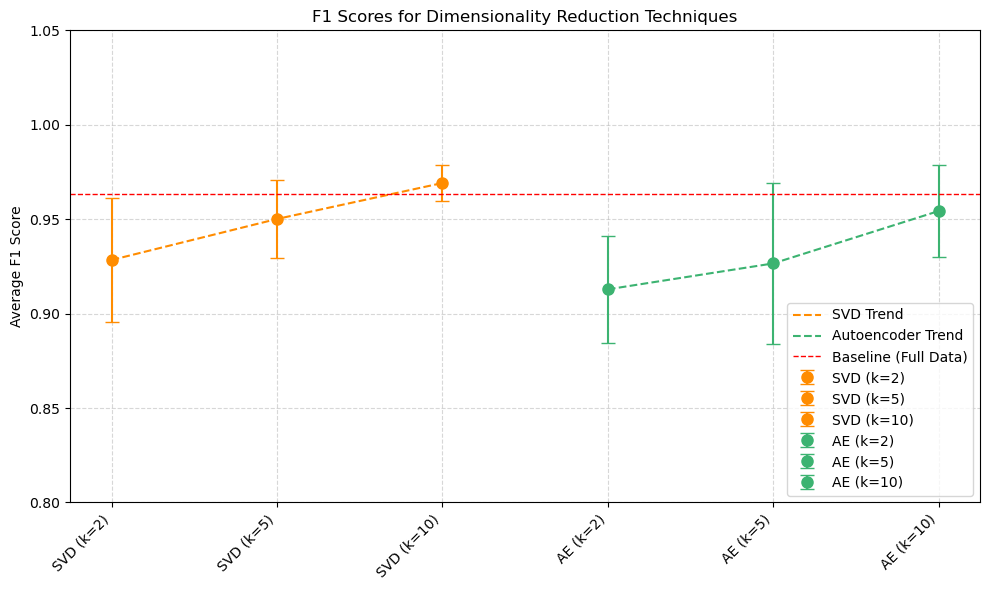

In [1042]:
plt.figure(figsize=(10, 6))

# SVD and AE colors
colors = ['darkorange'] * 3 + ['mediumseagreen'] * 3  

# error bars for each point
for i in range(len(labels)):
    plt.errorbar(i, means[i], yerr=stds[i], fmt='o', 
                 label=labels[i], color=colors[i], capsize=5, markersize=8)

# connect points with dashed lines
plt.plot([0, 1, 2], means[:3], linestyle='--', color='darkorange', label='SVD Trend')
plt.plot([3, 4, 5], means[3:], linestyle='--', color='mediumseagreen', label='Autoencoder Trend')

#plot the baseline computed above
plt.axhline(y=baseline_mean, color='red', linestyle='--', linewidth= 1 , label='Baseline (Full Data)')


# graph format, title and y axis
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Average F1 Score')
plt.title('F1 Scores for Dimensionality Reduction Techniques')
plt.ylim(0.80, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#### Results:

Success! My SVD and AutoEncoder worked as expected. They both improve their ability to predict / show my data as dimensions increase. Starting at 2 dimensions which is not enough data in order to show an entire dataset. As K increases, the predictability improves. 
I predict that if K gets too large, the predictability will plateau or drop, with too much noise conflicting the predictions. 

SVD is significantly better at predicting than AE, especially with the 10 dimensions. The reason for this is because of the matrix math behind SVD, the dimensions kept are the 10 most important dimensions to show the data. As a matter of fact, for every k input tested, the SVD model reflects a better score than the AE model. 

The Baseline shown in red is also a good indicator of predictability. SVD performs better than this line for k = 10, so for specific k values, there is a fairly efficient and correct way to predict the target. The challenge now is finding the righ k per problem. 